In [37]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [40]:
df = pd.read_csv('cleaned_spam_with_original1.csv')
X_raw = df['clean_text']  # Use cleaned text for training
tokenized_texts = X_raw.apply(lambda x: str(x).split())
y_raw = df['label']       # Target labels

In [41]:
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [42]:
def get_avg_word2vec(tokens, model, k=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.random.normal(scale=0.01, size=(k,)) 

In [43]:
# Create feature vectors
X_vectors = tokenized_texts.apply(lambda x: get_avg_word2vec(x, w2v_model))
X = np.vstack(X_vectors.values)

In [44]:
# Label encode the target (assuming 'label' column contains 'ham' and 'spam')
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [45]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Train SVM classifier with balanced class weights
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [47]:
# Predict & evaluate
y_pred = svm.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:

              precision    recall  f1-score   support

         ham       0.96      0.88      0.92       965
        spam       0.50      0.75      0.60       150

    accuracy                           0.86      1115
   macro avg       0.73      0.82      0.76      1115
weighted avg       0.90      0.86      0.87      1115



In [48]:
# Confusion matrix as labeled DataFrame
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:\n")
print(cm_df)

Confusion Matrix:

      ham  spam
ham   850   115
spam   37   113


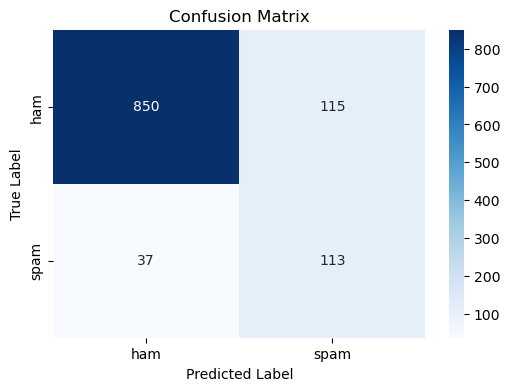

In [49]:
# Confusion matrix heatmap plot
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
print(df.head()[['clean_text', 'label']])

                                          clean_text label
0  go jurong point crazy available bugis n great ...   ham
1                              ok lar joking wif oni   ham
2  free entry 2 wkly comp win fa cup final tkts 2...  spam
3                    dun say early hor c already say   ham
4                nah think go usf life around though   ham


In [51]:
# Save the model
joblib.dump(svm, 'SPAM_PKL.pkl')

['SPAM_PKL.pkl']

In [52]:
joblib.dump((svm, w2v_model, le), 'SPAM1.pkl')

['SPAM1.pkl']